In [0]:
import requests  
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/drive')

###Парсинг IMDB

Выберем самые популярные жанры фильмов на IMDB и загрузим их в список genres

In [0]:
response = requests.get(f'https://www.imdb.com/chart/top/?ref_=nv_mv_250')
ki = BeautifulSoup(response.content, 'html.parser')
genres = []
for i in ki.find_all('li', class_="subnav_item_main"):
  genres.append(i.text.strip().lower())
genres = [ i for i in genres if i != 'film-noir'] #нуар уберем, их слишком мало
genres

Из каждого жанра достанем ссылки на фильмы с самым высоким рейтингом, где при этом число проглосовавших больше 25000

In [0]:
ssilki = []
for genre in tqdm(genres):
  response = requests.get(f'https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres={genre}&sort=user_rating,desc&start=0&ref_=adv_nxt')
  kin = BeautifulSoup(response.content, 'html.parser')
  upperbound =int(kin.find('div', class_="desc").text.split('of')[1].split('titles')[0].strip().replace(',', ''))
  number = 1
  while number < upperbound:
    response = requests.get(f'https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres={genre}&sort=user_rating,desc&start={number}&ref_=adv_nxt')
    kinch = BeautifulSoup(response.content, 'html.parser')
    for i  in kinch.find_all('h3', class_="lister-item-header"):
      ssilki.append(i.a.get('href'))
    print(genre + str(number))
    number += 50

In [0]:
len(ssilki)

15724

Сохраним ссылки в текстовый документ, чтоб не пропали)

In [0]:
f=open('ssilki.txt','w')
s1='\n'.join(ssilki)
f.write(s1)
from google.colab import files
files.download('ssilki.txt')

Прочитаем их из созданного файла

In [0]:
with open('/content/drive/My Drive/ssilki.txt') as f:
  ssil = f.read().split()
ssil

In [0]:
len(set(ssil)) #сколько всего будем выкачивать фильмов

5034

In [0]:
ssil = list(set(ssil))

Теперь напишем функцию, которая будет переходить по ссылкам из нашего списка и забирать информацию про фильмы

In [0]:
def imdb(i):
  lol = []
  try:
    response = requests.get(f'https://www.imdb.com{i}')
    film = BeautifulSoup(response.content, 'html.parser')
    lol.append(film.find('div', class_='title_wrapper').h1.text.strip().replace('\xa0','')) #название
    f = [i.text for i in film.find_all('div', class_="txt-block")]
    e = [i.text for i in film.find_all('div', class_="see-more inline canwrap")]
    try:
      lol.append(e[[j.find('\nGenres:') for j in e].index(0)].replace('\nGenres:', '').split()[0]) #жанр
    except:
      lol.append(np.nan)
    try:
      lol.append(f[[j.find('\nCountry') for j in f].index(0)].replace('Country:', '').split('|')[0].strip()) #страна производства, если несколько то 1
    except:
      lol.append(np.nan)
    try:
      lol.append(f[[j.find('\nLanguage:') for j in f].index(0)].replace('Language:', '').replace('|','').split()[0]) #язык
    except:
      lol.append(np.nan)
    try:
      lol.append(float(film.find('span', itemprop="ratingValue").text)) #рейтинг
    except:
      lol.append(np.nan)
    try:
      lol.append(int(film.find('span', itemprop="ratingCount").text.replace(",", ''))) #колво проголосовавших
    except:
      lol.append(np.nan)
    try:
      lol.append(int(f[[j.find('\nBudget:') for j in f].index(0)].replace('\nBudget:', '').split()[0].replace(',', '').replace('$',''))) #бюджет
    except:
      lol.append(np.nan)
    try:
      lol.append(int(f[[j.find('\nCumulative Worldwide Gross:') for j in f].index(0)].replace('\nCumulative Worldwide Gross:', '').split()[0].replace(',', '').replace('$',''))) #заработок в мире
    except:
      lol.append(np.nan)
    try:
      lol.append(film.find('div', class_="metacriticScore score_favorable titleReviewBarSubItem").text.strip()) #метакритик ревью
    except:
      lol.append(np.nan)
    try:
      lol.append(f[[j.find('\nColor') for j in f].index(0)].replace('Color:', '').replace('|','').split()[0]) #цвет
    except:
      lol.append(np.nan)
    try:
      lol.append(f[[j.find('\nSound Mix') for j in f].index(0)].replace('Sound Mix:', '').replace('|','').split()[0]) #звук
    except:
      lol.append(np.nan)
    try:
      lol.append(f[[j.find('\nRelease Date') for j in f].index(0)].replace('\nRelease Date:', '').split('(')[0].strip()) #дата выхода
    except:
      lol.append(np.nan)
    try:
      lol.append(film.time.text.strip()) #длительность
    except:
      lol.append(np.nan)
    return lol
  except:
    lol.append(np.nan)

С помощью мультипроцессинга, чтоб было быстрее, загрузим нужную информацию, а потом оформим датафрейм и сохраним его

In [0]:
%%time
from multiprocessing import Pool
with Pool(50) as p:
    yo = list(tqdm(p.imap(imdb, ssil)))

5034it [16:43,  5.02it/s]


CPU times: user 3.36 s, sys: 1.49 s, total: 4.85 s
Wall time: 16min 44s


In [0]:
df = pd.DataFrame(yo, columns=['Название', 'Жанр', 'Cтрана производства', 'Язык', 'Рейтинг', 'Количество проголосовавших','Бюджет', 'Заработок в мире', 'Metascore', 'Цвет', 'Звук', 'Дата выхода', 'Длительность'])
df

,Название,Жанр,Cтрана производства,Язык,Рейтинг,Количество проголосовавших,Бюджет,Заработок в мире,Metascore,Цвет,Звук,Дата выхода,Длительность
0,Robin Hood(2018),Action,USA,English,5.3,58894,100000000.0,86489031.0,NaN,Color,Dolby,21 November 2018,1h 56min
1,Finding Nemo(2003),Animation,USA,English,8.1,918678,94000000.0,940343261.0,90,Color,DTS,30 May 2003,1h 40min
2,A Serious Man(2009),Comedy,USA,English,7.0,128822,7000000.0,31430334.0,83,Color,DTS,6 November 2009,1h 46min
3,Detroit(2017),Crime,USA,English,7.3,45204,34000000.0,23355100.0,77,Color,Dolby,4 August 2017,2h 23min
4,Replicas(2018),Drama,UK,English,5.5,27748,30000000.0,9330075.0,NaN,Color,NaN,11 January 2019,1h 47min
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,In Bruges(2008),Comedy,UK,English,7.9,380040,15000000.0,34085749.0,67,Color,Dolby,29 February 2008,1h 47min
5030,The Changeling(1980),Horror,Canada,English,7.2,28625,NaN,NaN,70,Color,Dolby,28 March 1980,1h 47min
5031,The Zookeeper's Wife(2017),Biography,Czech Republic,English,7.0,36252,20000000.0,26152835.0,NaN,Color,Dolby,7 April 2017,2h 7min
5032,The Devil Inside(2012),Horror,USA,English,4.2,34423,1000000.0,101758490.0,NaN,Color,Dolby,6 January 2012,1h 23min


In [0]:
from google.colab import files
df.to_csv('imdb.csv') 
files.download('imdb.csv')

###Предварительная обработка

Теперь можем работать уже с готовым датафреймом

In [0]:
df = pd.read_csv('/content/drive/My Drive/imdb.csv', index_col=0)

In [76]:
df

,Название,Жанр,Cтрана производства,Язык,Рейтинг,Количество проголосовавших,Бюджет,Заработок в мире,Metascore,Цвет,Звук,Дата выхода,Длительность
0,Robin Hood(2018),Action,USA,English,5.3,58894,100000000.0,86489031.0,NaN,Color,Dolby,21 November 2018,1h 56min
1,Finding Nemo(2003),Animation,USA,English,8.1,918678,94000000.0,940343261.0,90.0,Color,DTS,30 May 2003,1h 40min
2,A Serious Man(2009),Comedy,USA,English,7.0,128822,7000000.0,31430334.0,83.0,Color,DTS,6 November 2009,1h 46min
3,Detroit(2017),Crime,USA,English,7.3,45204,34000000.0,23355100.0,77.0,Color,Dolby,4 August 2017,2h 23min
4,Replicas(2018),Drama,UK,English,5.5,27748,30000000.0,9330075.0,NaN,Color,NaN,11 January 2019,1h 47min
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,In Bruges(2008),Comedy,UK,English,7.9,380040,15000000.0,34085749.0,67.0,Color,Dolby,29 February 2008,1h 47min
5030,The Changeling(1980),Horror,Canada,English,7.2,28625,NaN,NaN,70.0,Color,Dolby,28 March 1980,1h 47min
5031,The Zookeeper's Wife(2017),Biography,Czech Republic,English,7.0,36252,20000000.0,26152835.0,NaN,Color,Dolby,7 April 2017,2h 7min
5032,The Devil Inside(2012),Horror,USA,English,4.2,34423,1000000.0,101758490.0,NaN,Color,Dolby,6 January 2012,1h 23min


In [77]:
df.isna().sum()

Название                         0
Жанр                             0
Cтрана производства              0
Язык                             0
Рейтинг                          0
Количество проголосовавших       0
Бюджет                         855
Заработок в мире               202
Metascore                     2874
Цвет                             4
Звук                           202
Дата выхода                      0
Длительность                     0
dtype: int64

Больше всего у нас пропусков в колонке с бюджетом и Metascore, однако потом можно будет что-то придумать со строками, где их нет, но есть
другая полезная информация, поэтому удалять и менять ничего не будем

Дата выхода и время у нас в не очень хорошем виде, поэтому переведем время в минуты, а дату в дейттайм

In [0]:
df['Дата выхода'] = df['Дата выхода'].str.replace('July', '07', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('August', '08', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('September', '09', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('October', '10', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('November', '11', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('December', '12', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('January', '01', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('February', '02', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('March', '03', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('April', '04', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('May', '05', regex=True)
df['Дата выхода'] = df['Дата выхода'].str.replace('June', '06', regex=True).str.replace(' ','-',regex=True)
df = df[df['Дата выхода'].map(len) > 8].reset_index(drop=True) # удалим строки, где нет точной даты выхода
df['Дата выхода'] = pd.to_datetime(df['Дата выхода'],format='%d-%m-%Y') # переведем в дейттайм

In [79]:
for i in range(len(df['Длительность'])): # здесь используем цикл, чтоб отловить фильмы со сложными длительностями
  if df['Длительность'][i][1] != 'h': # короткие фильмы, меньше часа
    df['Длительность'][i] = int(df['Длительность'][i].replace('min',''))
  elif len(df['Длительность'][i]) != 2: 
    df['Длительность'][i] = int(df['Длительность'][i].split()[0].replace('h',''))*60 + int(df['Длительность'][i].split()[1].replace('min',''))
  else:  #фильмы, которые длятся ровное количество часов без минут
    df['Длительность'][i] = int(df['Длительность'][i].replace('h',''))*60
df['Длительность']  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0       116
1       100
2       106
3       143
4       107
       ... 
5009    107
5010    107
5011    127
5012     83
5013     87
Name: Длительность, Length: 5014, dtype: object

Рейтинг критиков у нас имеет тип "строка", поэтому превтратим его в числовые показтели для удобства

In [0]:
df['Metascore'] = pd.to_numeric(df['Metascore'])

In [81]:
df

,Название,Жанр,Cтрана производства,Язык,Рейтинг,Количество проголосовавших,Бюджет,Заработок в мире,Metascore,Цвет,Звук,Дата выхода,Длительность
0,Robin Hood(2018),Action,USA,English,5.3,58894,100000000.0,86489031.0,NaN,Color,Dolby,2018-11-21,116
1,Finding Nemo(2003),Animation,USA,English,8.1,918678,94000000.0,940343261.0,90.0,Color,DTS,2003-05-30,100
2,A Serious Man(2009),Comedy,USA,English,7.0,128822,7000000.0,31430334.0,83.0,Color,DTS,2009-11-06,106
3,Detroit(2017),Crime,USA,English,7.3,45204,34000000.0,23355100.0,77.0,Color,Dolby,2017-08-04,143
4,Replicas(2018),Drama,UK,English,5.5,27748,30000000.0,9330075.0,NaN,Color,NaN,2019-01-11,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5009,In Bruges(2008),Comedy,UK,English,7.9,380040,15000000.0,34085749.0,67.0,Color,Dolby,2008-02-29,107
5010,The Changeling(1980),Horror,Canada,English,7.2,28625,NaN,NaN,70.0,Color,Dolby,1980-03-28,107
5011,The Zookeeper's Wife(2017),Biography,Czech Republic,English,7.0,36252,20000000.0,26152835.0,NaN,Color,Dolby,2017-04-07,127
5012,The Devil Inside(2012),Horror,USA,English,4.2,34423,1000000.0,101758490.0,NaN,Color,Dolby,2012-01-06,83


###Создание новых признаков

Интересно узнать, насколько оценки пользователей отличаются от оценок критиков - создадим новую колонку

In [0]:
df['Разница оценок'] = df['Рейтинг']-df['Metascore']/10

Также создадим колонку для прибыли 

In [0]:
df['Прибыль'] = df['Заработок в мире']-df['Бюджет']

Если бы у нас была возможность отменить съемки фильма, а раздать все деньги тем, кто за него проголосовал, сколько бы они получили?

In [0]:
df['Стоимость голоса'] = df['Бюджет']/df['Количество проголосовавших']

Также посмторим, сколько стоит снимать минуту каждого фильма

In [0]:
df['Стоимость 1 минуты'] = df['Бюджет']/df['Длительность']

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5014 entries, 0 to 5013
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Название                    5014 non-null   object        
 1   Жанр                        5014 non-null   object        
 2   Cтрана производства         5014 non-null   object        
 3   Язык                        5014 non-null   object        
 4   Рейтинг                     5014 non-null   float64       
 5   Количество проголосовавших  5014 non-null   int64         
 6   Бюджет                      4170 non-null   float64       
 7   Заработок в мире            4820 non-null   float64       
 8   Metascore                   2153 non-null   float64       
 9   Цвет                        5010 non-null   object        
 10  Звук                        4814 non-null   object        
 11  Дата выхода                 5014 non-null   datetime64[n

In [87]:
print(df['Cтрана производства'].nunique())
df['Cтрана производства'].unique()

52


array(['USA', 'UK', 'Germany', 'South Korea', 'China', 'Spain', 'Sweden',
       'Denmark', 'India', 'Colombia', 'Australia', 'Italy', 'France',
       'Turkey', 'Netherlands', 'Ireland', 'Finland', 'South Africa',
       'Switzerland', 'Mexico', 'Canada', 'Belgium', 'Hong Kong', 'Japan',
       'Norway', 'Brazil', 'Russia', 'Austria', 'New Zealand', 'Thailand',
       'Serbia', 'Soviet Union', 'West Germany', 'Indonesia',
       'Federal Republic of Yugoslavia', 'Czech Republic', 'Iran',
       'Pakistan', 'United Arab Emirates', 'Argentina', 'Poland',
       'Iceland', 'Hungary', 'Malta', 'Greece', 'Romania', 'Lebanon',
       'Kenya', 'Estonia', 'Chile', 'Taiwan', 'Algeria'], dtype=object)

Поскольку у нас всего 52 страны, создадим листы стран по континентам и сделаем новый столбец

In [0]:
europe =['UK','Germany','Malta','Belgium','Spain','Sweden','Italy','France','Russia','Czech Republic', 'Austria', 'Denmark', 'Netherlands','Finland', 'Turkey','Ireland', 'Hungary', 'Iceland','Greece','Switzerland', 'Norway','Poland','Estonia','Romania','Serbia' ]
not_exist = ['Soviet Union','West Germany','Federal Republic of Yugoslavia']
asia = ['Japan','India','Thailand','Pakistan','Indonesia','Lebanon','United Arab Emirates', 'Iran','Taiwan','China', 'Hong Kong', 'South Korea']
africa = ['South Africa','Algeria','Kenya']
north_america = ['USA', 'Canada','Mexico']
south_america = ['Brazil','Argentina','Chile','Colombia']
oceania = ['New Zealand','Australia']

In [89]:
df["Континент"] = np.nan
for i in range(len(df['Cтрана производства'])):
  if df['Cтрана производства'][i] in europe:
   df['Континент'][i] = 'Europe'
  if df['Cтрана производства'][i] in asia:
    df['Континент'][i] = 'Asia'
  if df['Cтрана производства'][i] in not_exist:
    df['Континент'][i] = 'Not exist'
  if df['Cтрана производства'][i] in africa:
    df['Континент'][i] = 'Africa'
  if df['Cтрана производства'][i] in north_america:
    df['Континент'][i] = 'North America'
  if df['Cтрана производства'][i]in south_america:
    df['Континент'][i] = 'South America'
  if df['Cтрана производства'][i]in oceania:
    df['Континент'][i] = 'Oceania'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/

Также создадим колонку с временами года

In [90]:
df['Время года'] = np.nan
df['Время года'][(df['Дата выхода'].dt.month <12) & (df['Дата выхода'].dt.month >8)] = 'Autumn'
df['Время года'][(df['Дата выхода'].dt.month <9) & (df['Дата выхода'].dt.month >5)] = 'Summer'
df['Время года'][(df['Дата выхода'].dt.month <6) & (df['Дата выхода'].dt.month >2)] = 'Spring'
df['Время года'][(df['Дата выхода'].dt.month <3) | (df['Дата выхода'].dt.month >11)] = 'Winter'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [91]:
df.head()

,Название,Жанр,Cтрана производства,Язык,Рейтинг,Количество проголосовавших,Бюджет,Заработок в мире,Metascore,Цвет,Звук,Дата выхода,Длительность,Разница оценок,Прибыль,Стоимость голоса,Стоимость 1 минуты,Континент,Время года
0,Robin Hood(2018),Action,USA,English,5.3,58894,100000000.0,86489031.0,NaN,Color,Dolby,2018-11-21,116,NaN,-13510969.0,1697.965837,862069,North America,Autumn
1,Finding Nemo(2003),Animation,USA,English,8.1,918678,94000000.0,940343261.0,90.0,Color,DTS,2003-05-30,100,-0.9,846343261.0,102.320944,940000,North America,Spring
2,A Serious Man(2009),Comedy,USA,English,7.0,128822,7000000.0,31430334.0,83.0,Color,DTS,2009-11-06,106,-1.3,24430334.0,54.338545,66037.7,North America,Autumn
3,Detroit(2017),Crime,USA,English,7.3,45204,34000000.0,23355100.0,77.0,Color,Dolby,2017-08-04,143,-0.4,-10644900.0,752.145828,237762,North America,Summer
4,Replicas(2018),Drama,UK,English,5.5,27748,30000000.0,9330075.0,NaN,Color,NaN,2019-01-11,107,NaN,-20669925.0,1081.159002,280374,Europe,Winter


###Визуализация

Посмотрим, фильмы из каких стран и континентов попали в наш список фильмов и в каком количестве

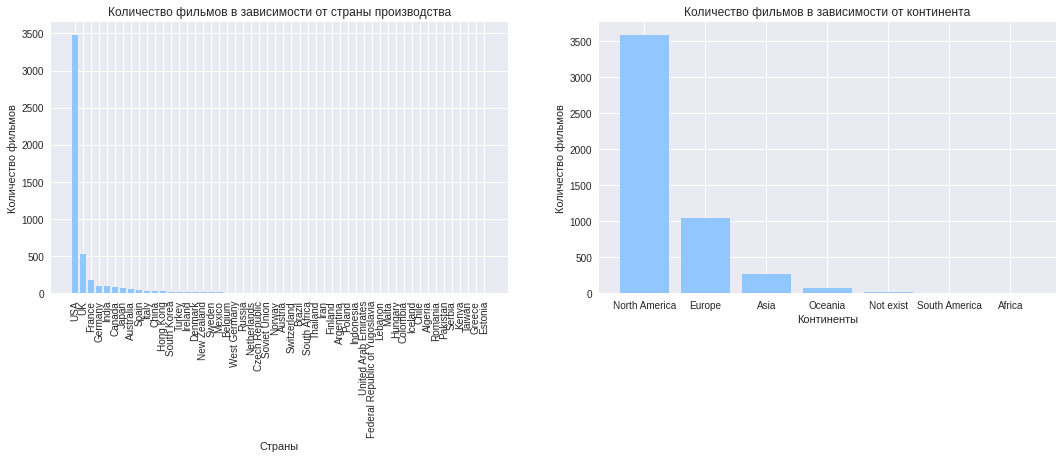

In [92]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(ncols=2,figsize = (18,5))
ax[0].bar(pd.value_counts(df['Cтрана производства']).index,height=pd.value_counts(df['Cтрана производства']))
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title('Количество фильмов в зависимости от страны производства')
ax[0].set_xlabel('Страны')
ax[0].set_ylabel('Количество фильмов')
ax[1].bar(pd.value_counts(df['Континент']).index,height=pd.value_counts(df['Континент']))
ax[1].set_title('Количество фильмов в зависимости от континента')
ax[1].set_xlabel('Континенты')
ax[1].set_ylabel('Количество фильмов')
plt.show()

In [93]:
df.corr() # матрица коореляции

,Рейтинг,Количество проголосовавших,Бюджет,Заработок в мире,Metascore,Разница оценок,Прибыль,Стоимость голоса
Рейтинг,1.000000,0.363455,-0.085161,0.072948,0.516797,0.122484,0.162316,-0.437946
Количество проголосовавших,0.363455,1.000000,0.358404,0.562963,0.140126,0.179551,0.553926,-0.258528
Бюджет,-0.085161,0.358404,1.000000,0.725680,-0.152578,0.162108,0.591976,0.463337
Заработок в мире,0.072948,0.562963,0.725680,1.000000,-0.017445,0.115838,0.984109,0.054295
Metascore,0.516797,0.140126,-0.152578,-0.017445,1.000000,-0.786362,0.024573,-0.312463
Разница оценок,0.122484,0.179551,0.162108,0.115838,-0.786362,1.000000,0.102779,0.056308
Прибыль,0.162316,0.553926,0.591976,0.984109,0.024573,0.102779,1.000000,-0.053761
Стоимость голоса,-0.437946,-0.258528,0.463337,0.054295,-0.312463,0.056308,-0.053761,1.000000


Построим несколько интересных диаграмм рассеяния и попробуем их проинтерпретировать

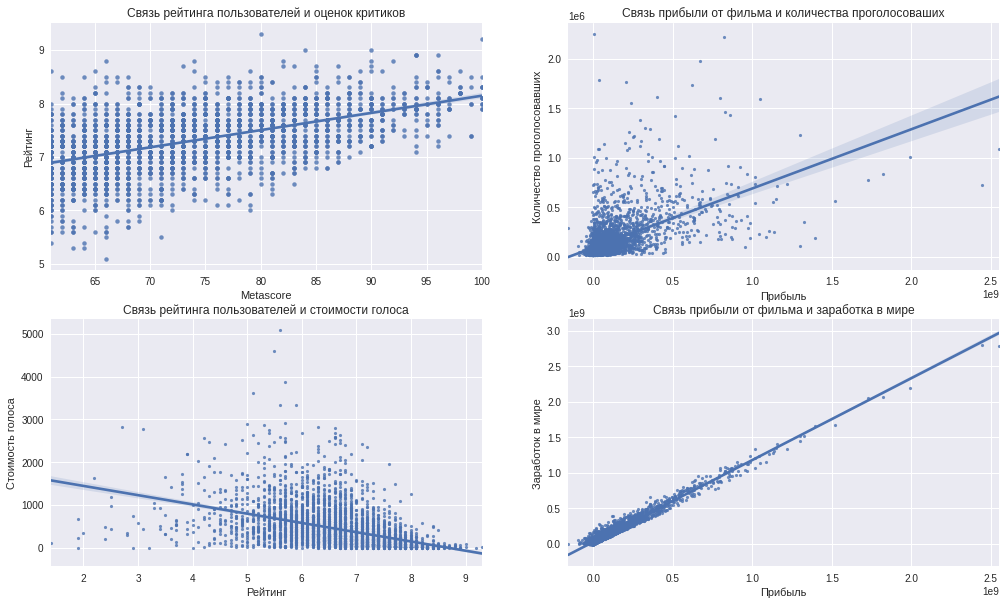

In [94]:
plt.style.use('seaborn')
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(17,10))
sns.regplot('Metascore', 'Рейтинг',data=df,fit_reg=True,ax=ax[0,0], scatter_kws={'s':20})
ax[0,0].set_title('Связь рейтинга пользователей и оценок критиков')
sns.regplot('Прибыль', 'Заработок в мире',data=df,fit_reg=True, scatter_kws={'s':10},ax=ax[1,1])
ax[1,1].set_title('Связь прибыли от фильма и заработка в мире')
sns.regplot('Прибыль', 'Количество проголосовавших',data=df,fit_reg=True, scatter_kws={'s':10},ax=ax[0,1])
ax[0,1].set_title('Связь прибыли от фильма и количества проголосоваших')
sns.regplot('Рейтинг', 'Стоимость голоса',data=df,fit_reg=True, scatter_kws={'s':10},ax=ax[1,0])
ax[1,0].set_title('Связь рейтинга пользователей и стоимости голоса')
plt.show()

1.   Наблюдается положительная связь между оценками критиков и зрителей, однако она не настолько сильна, как можно было этого ожидать. 
2.   Связь прибыли и заработка имеет очень четкую положительную связь, что говорит о важности величины заработка для получения высокой прибыли, при этом значимость бюджета сильно меньше (корреляция прибыли и бюджета 0.591976). 
3.Интересно, что связь оценки за фильм и денег, которые мог бы получить каждый голосовавший имеет сильную отрицательную связь. Если будут раздавать деньги за голоса, не ставьте оценки фильмам с высоким рейтингом)
4.Положительная связь прибыль и количества проголосовавших может интерпретироваться через посещаемость кинотеатров. Люди больше ходят в кино на фильм - свят больше голосов и добавляют больше прибыли компании

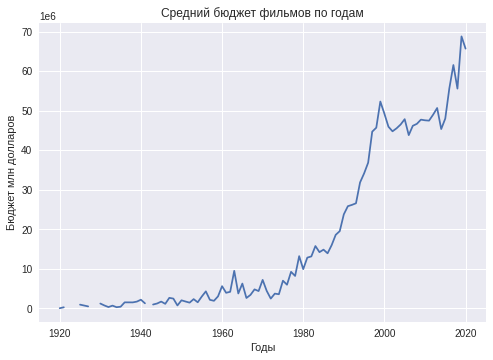

In [95]:
fig, ax = plt.subplots()
ax.plot(df[['Бюджет','Дата выхода']].groupby(df['Дата выхода'].dt.year).mean())
ax.set_title('Средний бюджет фильмов по годам')
ax.ticklabel_format(style='sci',scilimits=(6, 6), axis='y')
ax.set_xlabel('Годы')
ax.set_ylabel('Бюджет млн долларов')
plt.show()

Интересно заметитить, как росли средние бюджеты, затраченные на производство фильмов каждый год

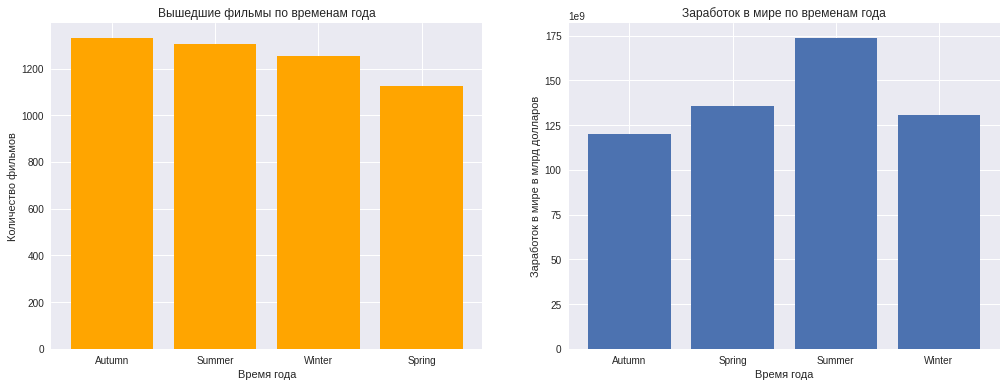

In [96]:
fig, ax = plt.subplots(ncols=2, figsize =(17,6))
ax[0].bar(pd.value_counts(df['Время года']).index, height = pd.value_counts(df['Время года']), color=('orange'))
ax[0].set_title('Вышедшие фильмы по временам года')
ax[0].set_xlabel('Время года')
ax[0].set_ylabel('Количество фильмов')
ax[1].bar(df[['Заработок в мире','Время года']].groupby(df['Время года']).sum().index, df[['Заработок в мире','Время года']].groupby(df['Время года']).sum()['Заработок в мире'])
ax[1].ticklabel_format(style='sci',scilimits=(9, 9), axis='y')
ax[1].set_title('Заработок в мире по временам года')
ax[1].set_xlabel('Время года')
ax[1].set_ylabel('Заработок в мире в млрд долларов')
plt.show()

Больше всего хороших фильмов выходит весной и осенью, что может быть связано с тем, что все основные кинофестивали проходят в первой половине года, а сами фильмы добираются до широкого экрана как раз к осеннему сезону. При этом больше всего зарабатывают фильмы, вышедшие летом, что скорее всего связано с сезоном каникул и отпусков - у людей больше времени на кино

###Гипотезы

Придумаем и протестируем гипотезы:
1. В среднем фильмы, выпущенные на английском языке зарабатывают больше а длятся меньше, чем другие
2. Критики ставят в среднем самые низкие оценки комедиям, в то время людям меньше всего нравятся мелодрамы
3. Если бюджет фильма превышает 200 000 000 $, значит, он выпущен в США
4. Все немые фильмы в нашей подборке - черно-белые
5. Выборочная несмещенная дисперсия для прибыли немецких фильмов больше, чем для французских
6. Критики и зрители более единогласны в оценках относительно фильмов, выпущенных в Европе, нежели в Азии, то есть сумма модулей разниц оценок для Европы меньше
7. Если рейтинг фильма ниже 5 и он вышел в 20 веке, то он точно снят не в Южной Америке или Азии



In [97]:
#1 В среднем фильмы, выпущенные на английском языке зарабатывают больше а длятся меньше, чем другие
eng = df[df['Язык'] == 'English']['Заработок в мире'].mean()
noteng = df[df['Язык'] != 'English']['Заработок в мире'].mean()
verno = 0
if eng > noteng:
  print(f'{eng:.10} > {noteng:.10}: фильмы на английском зарабатывают больше')
  verno +=1
else:
  print(f'{eng:.10} < {noteng:.10}: фильмы на английском зарабатывают меньше')
dliteng = df[df['Язык'] == 'English']['Длительность'].mean()
dlitnoteng = df[df['Язык'] != 'English']['Длительность'].mean()
if dliteng > dlitnoteng:
  print(f'{dliteng:.10} > {dlitnoteng:.10}: фильмы на английском длятся дольше')
else:
  print(f'{dliteng:.10} < {dlitnoteng:.10}: фильмы на английском длятся меньше')
  verno +=1
if verno ==2:
  print('Наша гипотеза верна')
else:
  print('Наша гипотеза неверна')

126249570.7 > 34197461.3: фильмы на английском зарабатывают больше
109.8324373 < 122.0490909: фильмы на английском длятся меньше
Наша гипотеза верна


In [163]:
#2 Критики ставят в среднем самые низкие оценки комедиям, в то время людям меньше всего нравятся мелодрамы
genre = df[['Жанр', 'Metascore', 'Рейтинг']].groupby('Жанр').mean() #отберем нужные нам колонки и посчитаем среднее
if genre[genre['Metascore']==genre['Metascore'].min()].index[0] == 'Comedy' and genre[genre['Рейтинг']==genre['Рейтинг'].min()].index[0] == 'Romance':
  print('Наша гипотеза верна, критики меньше всего любят комедии, а люди мелордрамы ')
else:
  x = genre[genre['Metascore']==genre['Metascore'].min()].index[0]
  y = genre[genre['Рейтинг']==genre['Рейтинг'].min()].index[0]
  print(f'Наша гипотеза неверна, критики меньше всего любят {x}, а люди {y}')

Наша гипотеза неверна, критики меньше всего любят Sci-Fi, а люди Fantasy


In [62]:
#3 Если бюджет фильма превышает 200 000 000 $, значит, он выпущен в США
n = 200 #миллионов долларов, можно задать другой n и потестить гипотезу
if n*10**6 < df['Бюджет'].max():
  x = df[df['Бюджет']>n*10**6].loc[lambda df: df[df['Бюджет']>n*10**6]['Cтрана производства']!='USA'] # страны, где снимали фильмы с бюджетом больше 200 000 000 $
  if len(x) !=0:
    strani = x['Cтрана производства'].unique()
    print(f'Наша гипотеза неверна \nВот страны в которых выпускались фильмы c бюджетом больше {n} млн  долларов: {strani}')
  else:
    print(f'Наша гипотеза верна \nТолько в США выпускались фильмы c бюджетом больше {n} млн  долларов')
else:
  print(f'Фильмы с бюджетом {n} млн долларов не выпускались нигде')

Наша гипотеза неверна 
Вот страны в которых выпускались фильмы c бюджетом больше 200 млн  долларов: ['UK' 'New Zealand' 'China' 'Canada']


In [104]:
#4 Все немые фильмы в нашей подборке - черно-белые
if len(df[df['Звук'] == 'Silent']) == len(df[df['Звук'] == 'Silent'][df[df['Звук'] == 'Silent']['Цвет'] == 'Black']):
  x=df[df['Звук'] == 'Silent']['Название'].unique()
  print(f'Наша гипотеза верна - вот эти фильмы:{x}')
else:
  print('Наша гипотеза неверна')

Наша гипотеза верна - вот эти фильмы:['The Cabinet of Dr. Caligari(1920)' 'Nosferatu(1922)'
 'Sherlock Jr.(1924)' 'The General(1926)' 'City Lights(1931)'
 'The Passion of Joan of Arc(1928)' 'Battleship Potemkin(1925)']


In [122]:
#5 Выборочная несмещенная дисперсия для прибыли немецких фильмов больше, чем для французских
nem = df[df['Cтрана производства'] == 'Germany']
vibdispnem = ((np.array(nem['Прибыль'].dropna())-nem['Прибыль'].mean())**2).sum()/(len(nem)-1)
fran = df[df['Cтрана производства'] == 'France']
vibdispfran = ((np.array(fran['Прибыль'].dropna())-fran['Прибыль'].mean())**2).sum()/(len(fran)-1)
if vibdispnem > vibdispfran:
  print(f'Наша гипотеза верна \nВыборочная несмещенная дисперсия для немецких фильмов больше, так как: {vibdispnem}>{vibdispfran}')
else:
  print(f'Наша гипотеза неверна \nВыборочная несмещенная дисперсия для немецких фильмов меньше, так как: {vibdispnem}<{vibdispfran}')

Наша гипотеза неверна 
Выборочная несмещенная дисперсия для немецких фильмов меньше, так как: 3311742069357280.0<4645992745965328.0


In [140]:
#6 Критики и зрители более единогласны в оценках относительно фильмов, выпущенных в Европе, нежели в Азии, 
#то есть сумма модулей разниц оценок деленная на их количество для Европы меньше
df['Разница оценок'] = abs(df['Разница оценок'])
contin = df[['Разница оценок', 'Континент']].groupby('Континент').sum() #сгруппируем по континентам
asi = contin.loc['Asia'][0]/pd.value_counts(df['Континент']).loc['Asia'] #для Европы
eur = contin.loc['Europe'][0]/pd.value_counts(df['Континент']).loc['Europe'] #для Азии
if eur < asi:
  print(f'Наша гипотеза верна \nКритики и зрители более единогласны в оценках относительно фильмов, выпущенных в Европе, {eur: .5} < {asi: .5}')
else:
  print(f'Наша гипотеза неверна \nКритики и зрители более единогласны в оценках относительно фильмов, выпущенных в Азии, {eur: .5} > {asi: .5}')

Наша гипотеза неверна 
Критики и зрители более единогласны в оценках относительно фильмов, выпущенных в Азии,  0.34967 >  0.26679


In [154]:
#7 Если рейтинг фильма ниже 5 и он вышел в 20 веке, то он точно снят не в Южной Америке или Азии
rate = 5 #можно поменять рейтинг и потестировать 
year = 2001 #можно поменять год и потестировать 
dat = df[(df['Рейтинг']<rate) & (df['Дата выхода'].dt.year < year)]
if 'Asia' not in dat['Континент'].unique() and 'South America' not in dat['Континент'].unique():
  print('Наша гипотеза верна, точно снят не в Южной Америке или Азии')
elif 'Asia' in dat['Континент'].unique() and 'South America' not in dat['Континент'].unique():
  print('Наша гипотеза неверна, он может быть снят в Азии')
elif 'Asia' not in dat['Континент'].unique() and 'South America'  in dat['Континент'].unique():
  print('Наша гипотеза неверна, он может быть снят в Южной Америке')
else:
  print('Наша гипотеза неверна, он может быть снят и в Южной Америке, и в Азии')

Наша гипотеза неверна, он может быть снят в Азии
